# Obtain the angle resolved grain maps of PARADIM-2

In [41]:
%run -i ../tomography/utils.py
%run -i startup3.py

Namespace: ['AzimuthalIntegrator', 'In', 'Out', 'annotate_peaks', 'assign_Q_to_atlas', 'create_atlas', 'create_atlas_dask', 'create_dataset', 'create_grain_maps', 'create_windows_from_size', 'create_windows_from_width', 'data', 'db_ana', 'db_cdf', 'db_csv', 'db_raw', 'df_uid', 'draw_windows', 'exit', 'get_ipython', 'get_vlim', 'image_data', 'min_and_max_along_time', 'mpl', 'my_print', 'np', 'patches', 'pd', 'pixel_to_Q', 'plot_grain_maps', 'plot_real_aspect', 'plt', 'quit', 'reformat_data', 'reshape', 'reshape_to_matrix', 'reshape_to_xarray', 'run', 'set_real_aspect', 'set_verbose', 'subtracted_shadow', 'tp', 'track_peaks', 'typing', 'windows', 'xr']


## Shadow method

### Load and reformat the data

In [5]:
run = db_raw[df_uid['uid'][4]]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [6]:
data

<xarray.Dataset>
Dimensions:              (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 1001)
Coordinates:
  * frame                (frame) int64 0 1 2 3 4 5 ... 995 996 997 998 999 1000
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image         (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mPhi                 (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mPhi_user_setpoint   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

### Test the method

We iterate the images along the time series and find the maximum and minimum values on each pixel. The images of the maximum values are like a photo of all shadows of the Bragg peaks on the detector while the ones of the minimum values are like the record of the lowest background intensities on the images.

This method is implemented in `min_and_max_along_time`.

### Analyze the result

The method will catch the powder diffraction in it. We need to filter the images and only apply the method on the images of non-powder part.

In [24]:
shadows = db_cdf.get_data("60c22a29d5a6c13acae330b9")["shadow"]

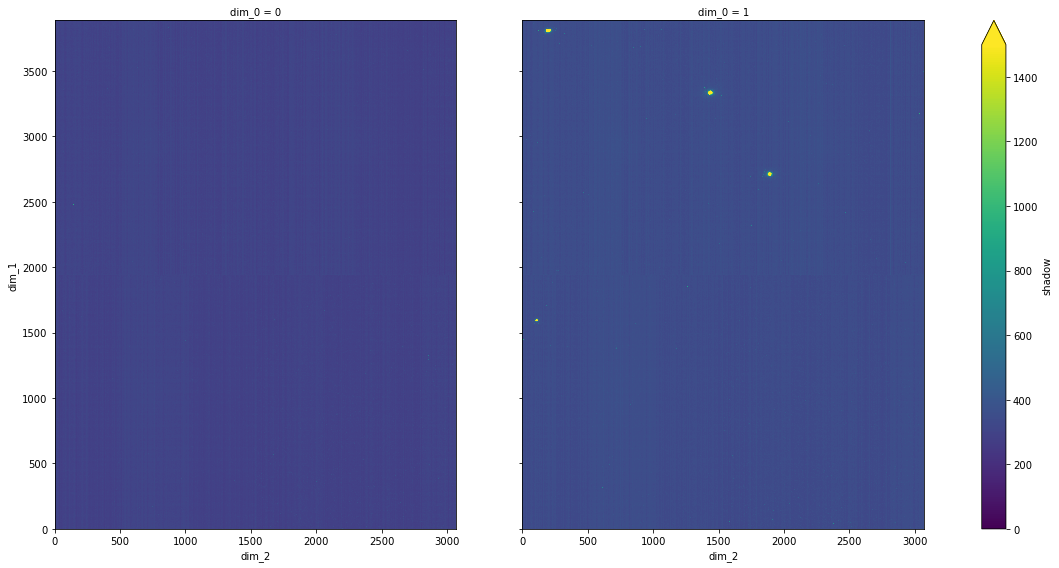

In [25]:
facet = shadows.plot(col="dim_0", vmax=1500, size=8)
set_real_aspect(facet.axes)

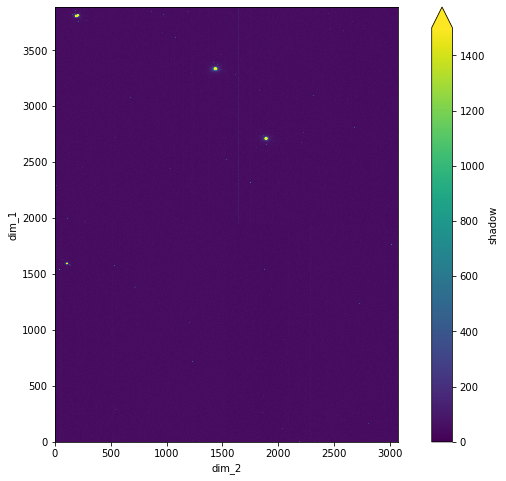

In [26]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)

In [27]:
del shadows, facet

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

### Select the ones to track

We select the 20 largest peaks to track.

In [32]:
peaks = db_csv.get_data("60c22bd7d5a6c13acae330ba")
windows = create_windows_from_size(peaks, 4.5)

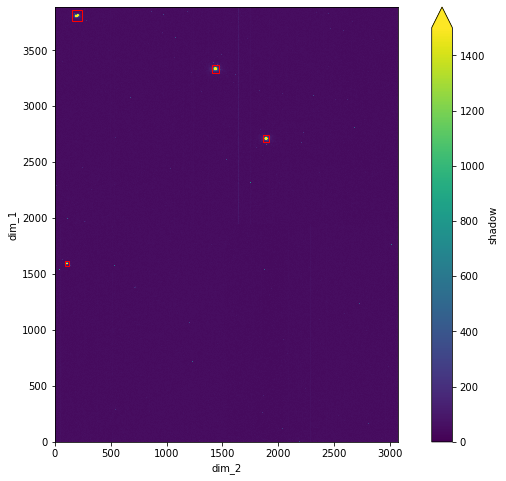

In [35]:
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)

In [36]:
del peaks, facet

### Run the tracking

### Visualize the grain maps

The intensity is plotted as a function of rotation angle.

In [69]:
grains = db_cdf.get_data("60c2411ad5a6c13acae330c5")
grains = grains.set_index({"grain": ["x", "y"]})

In [70]:
grains["maps"].attrs["standard_name"] = "I"
grains["maps"].attrs["units"] = "A. U."
grains["dim_0"].attrs["standard_name"] = "θ"
grains["dim_0"].attrs["units"] = "deg"

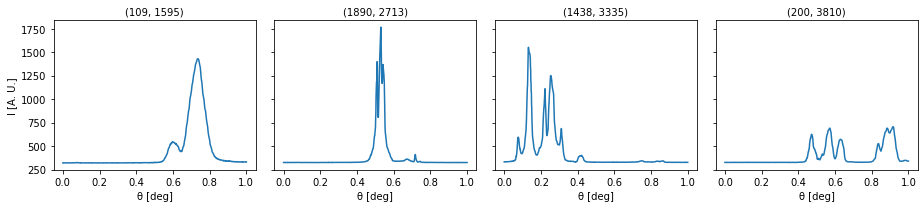

In [71]:
facet = grains["maps"].plot(col="grain")
facet.set_titles(template="{value}");

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [72]:
mean_map = grains["maps"].mean(axis=1)

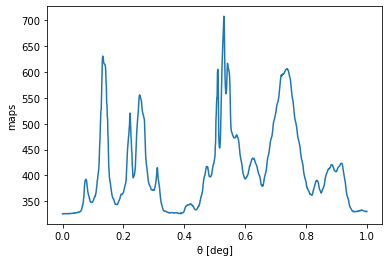

In [73]:
facet = mean_map.plot()